## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

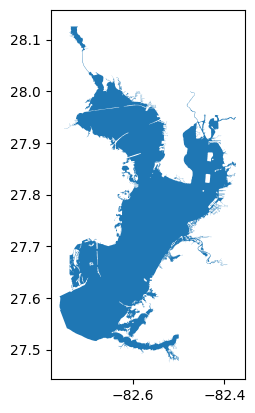

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(16226, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(16226, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

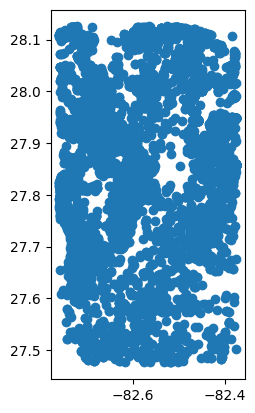

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

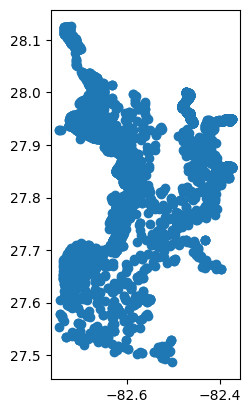

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10720

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,58,60,61,63,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475274,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1475275,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1475276,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1475277,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

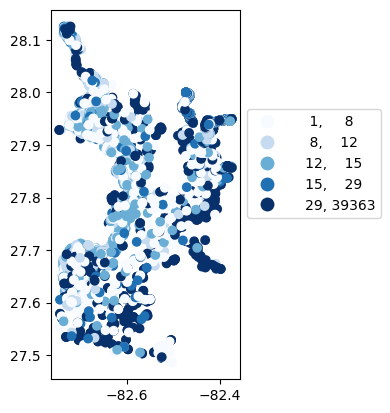

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    87241.000000
mean         1.469177
std          0.902037
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 219
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.881397411106354): 48


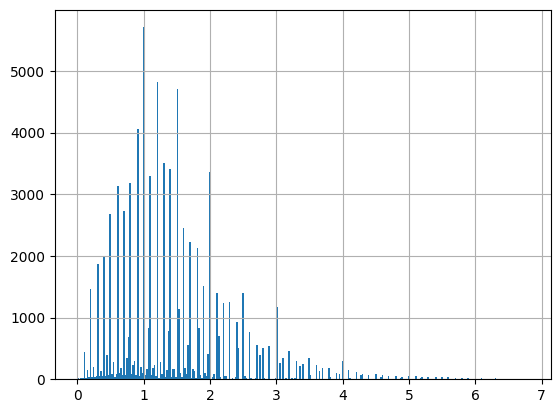

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
36,21FLHILL_WQX-1510,0.80,m,NaN,m,0.8 meter
68,21FLMANA_WQX-428,2.2,m,NaN,m,2.2 meter
96,21FLHILL_WQX-096,2.70,m,NaN,m,2.7 meter
106,21FLHILL_WQX-064,0.80,m,NaN,m,0.8 meter
127,21FLCOSP_WQX-COSPE6-2,1.7,m,NaN,m,1.7 meter
...,...,...,...,...,...,...
1474925,21FLPDEM_WQX-W8-B-24-01,3.1,m,NaN,m,3.1 meter
1474932,21FLPDEM_WQX-W7-B-24-02,1.6,m,NaN,m,1.6 meter
1474935,21FLPDEM_WQX-W7-B-24-01,3.128,m,NaN,m,3.128 meter
1474976,21FLTPA_WQX-G1SW0136,0.5,m,NaN,m,0.5 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
734900,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
739786,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
743105,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
745032,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
746511,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1460090,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460418,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460423,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460626,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
244340,NARS_WQX-NCCA10-1674,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
734900,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
739786,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
743105,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
745032,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1460090,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460418,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460423,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1460626,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
11832,USGS-280630082350900,3,1.966667
11833,USGS-280635082322100,2,2.100000
11834,USGS-280640082434700,3,2.302933
11835,USGS-280719082291400,2,1.000000


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


<Axes: >

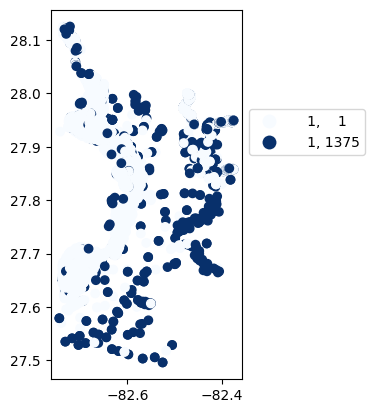

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

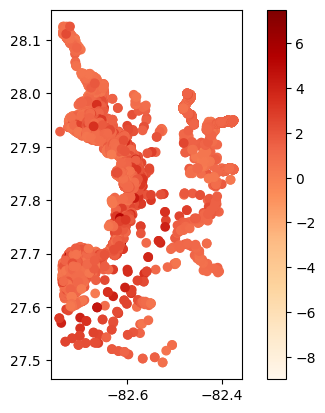

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    301964.000000
mean         25.302932
std          79.645591
min          -2.900000
25%          21.210000
50%          25.900000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 166
Usable results with inferred units: 0
Results outside threshold (0.0 to 503.176478477458): 2


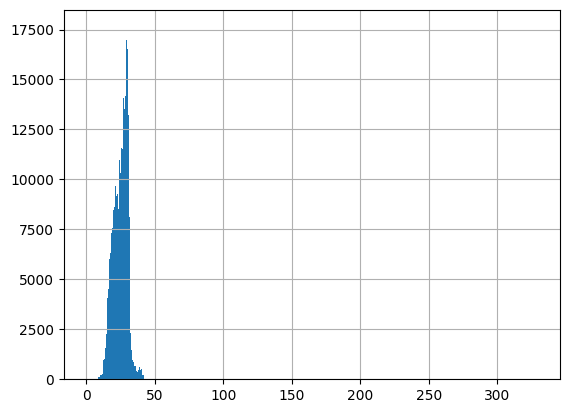

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
9,21FLTBW_WQX-M23,29.52,deg C,NaN,29.52 degree_Celsius,degC
14,21FLMANA_WQX-GA1,21,deg C,NaN,21.0 degree_Celsius,degC
34,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
37,21FLTBW_WQX-PR103026,17.73,deg C,NaN,17.73 degree_Celsius,degC
...,...,...,...,...,...,...
1475263,USGS-273217082335701,28.9,deg C,NaN,28.9 degree_Celsius,degC
1475266,USGS-274322082245501,24.4,deg C,NaN,24.4 degree_Celsius,degC
1475271,USGS-274302082280801,25.0,deg C,NaN,25.0 degree_Celsius,degC
1475274,USGS-273926082304501,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
739028,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
740113,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
741546,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
746594,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
752680,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
893028,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
896706,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1362248,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1444305,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
739028,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
740113,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
741546,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
746594,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
752680,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1418840,21FLPDEM_WQX-12-02,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1444305,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1444588,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1474642,21FLPDEM_WQX-24-01,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
15037,USGS-280726082313300,4,28.025000
15038,USGS-280728082301101,54,25.083333
15039,USGS-280729082313501,1,27.400000
15040,USGS-280730082313201,1,24.700000


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

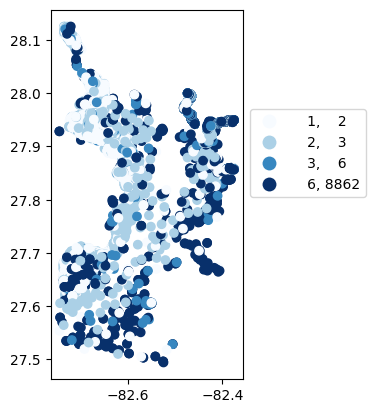

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

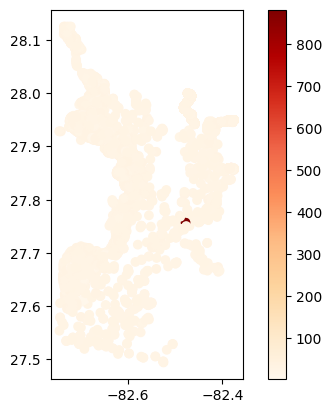

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1474946,21FLPDEM_WQX-14-02,8.16,mg/L,NaN,8.16 milligram / liter
1474956,21FLTPA_WQX-G2SW0138,0.49,mg/L,NaN,0.49 milligram / liter
1474961,21FLTPA_WQX-G1SW0126,10.15,mg/L,NaN,10.15 milligram / liter
1474977,21FLHESD_WQX-BEAUDETTE POND OUTLET,8.40,mg/L,NaN,8.4 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1474946,21FLPDEM_WQX-14-02,8.16,mg/L,NaN,8.16 milligram / liter
1474956,21FLTPA_WQX-G2SW0138,0.49,mg/L,NaN,0.49 milligram / liter
1474961,21FLTPA_WQX-G1SW0126,10.15,mg/L,NaN,10.15 milligram / liter
1474977,21FLHESD_WQX-BEAUDETTE POND OUTLET,8.40,mg/L,NaN,8.4 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
13610,NARS_WQX-NCCA10-1672,8,5.437500
13611,NARS_WQX-NCCA10-1673,20,4.115000
13612,NARS_WQX-NCCA10-1674,6,2.466667
13613,NARS_WQX-NLA06608-0161,5,6.500000


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

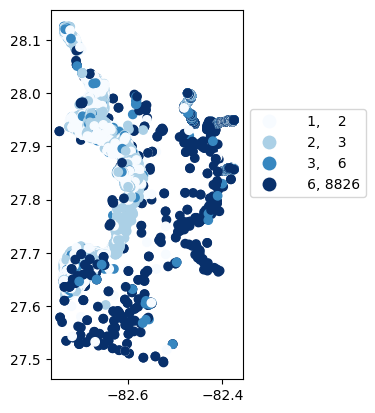

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

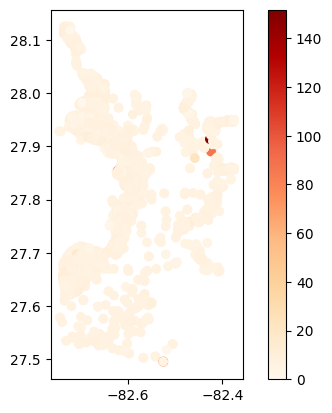

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

-Usable results-
count    278289.000000
mean          7.762995
std           0.472536
min           0.370000
25%           7.520000
50%           7.898646
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 186
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.598211492474329): 7


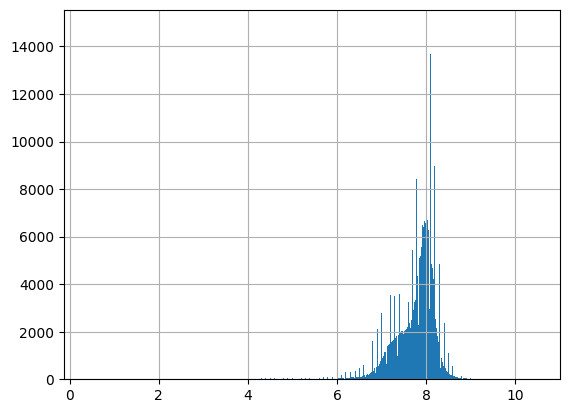

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,None,NaN,7.48 dimensionless
5,8.18,None,NaN,8.18 dimensionless
7,7.81,None,NaN,7.81 dimensionless
11,7.96,None,NaN,7.96 dimensionless
17,7.92,None,NaN,7.92 dimensionless
...,...,...,...,...
1475272,7.9,std units,NaN,7.9 dimensionless
1475273,7.3,std units,NaN,7.3 dimensionless
1475275,7.8,std units,NaN,7.8 dimensionless
1475276,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

-Usable results-
count    269049.000000
mean         21.708380
std          95.024786
min          -0.020000
25%          18.060000
50%          24.900000
75%          28.650000
max       48930.000000
dtype: float64
Unusable results: 1265
Usable results with inferred units: 0
Results outside threshold (0.0 to 591.8570961272843): 4


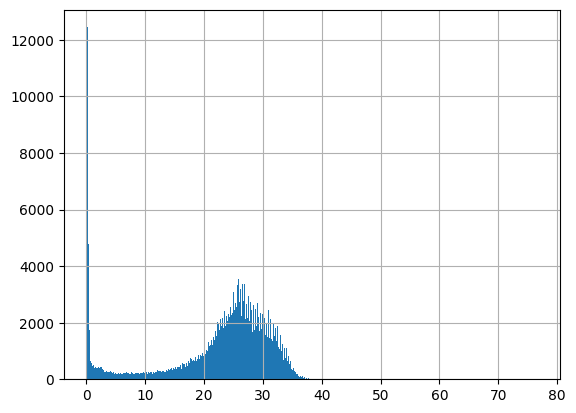

In [48]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
21,0.18,ppth,NaN,0.18 Practical_Salinity_Units
23,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1474954,0.37,ppth,NaN,0.37 Practical_Salinity_Units
1474965,34.41,ppth,NaN,34.41 Practical_Salinity_Units
1474968,18.14,ppth,NaN,18.14 Practical_Salinity_Units
1474970,0.56,ppth,NaN,0.56 Practical_Salinity_Units


##### Nitrogen

-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


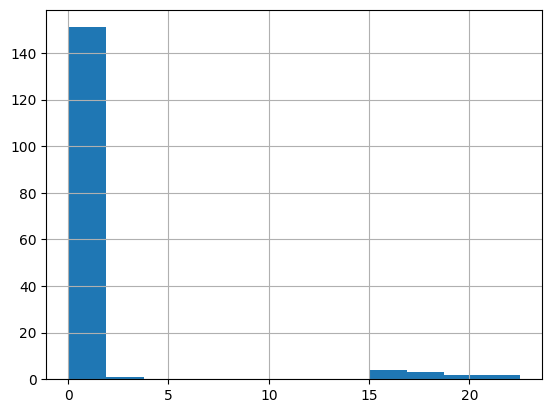

In [50]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
221551,0.39,mg/L,NaN,0.39 milligram / liter
237684,0.4475,mg/L,NaN,0.4475 milligram / liter
240477,0.425,mg/L,NaN,0.425 milligram / liter
254309,0.4625,mg/L,NaN,0.4625 milligram / liter
255698,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1472938,0.084,mg/l,NaN,0.084 milligram / liter
1472946,0.166,mg/l,NaN,0.166 milligram / liter
1472956,0.091,mg/l,NaN,0.091 milligram / liter
1472990,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

-Usable results-
count       11.000000
mean      2503.363636
std       5969.279978
min        606.000000
25%        629.500000
50%        775.000000
75%        776.000000
max      20500.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 38319.04350375742): 0


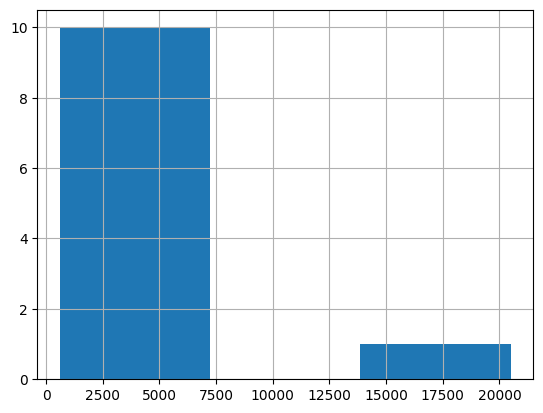

In [52]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
436005,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
440696,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
442133,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
444571,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
445435,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
447223,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
451907,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
468050,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
479556,626,uS/cm,NaN,626.0 microsiemens / centimeter
483915,688,uS/cm,NaN,688.0 microsiemens / centimeter


##### Chlorophyll a

-Usable results-
count    43334.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008725
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.1508140878070869): 197


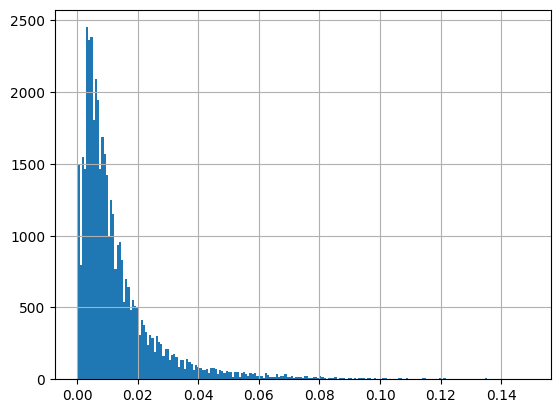

In [54]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
221067,5.94,ug/L,NaN,0.005940000000000001 milligram / liter
226038,1.45,ug/L,NaN,0.00145 milligram / liter
226973,2.77,ug/L,NaN,0.00277 milligram / liter
227824,3.87,ug/L,NaN,0.00387 milligram / liter
235915,8.15,ug/L,NaN,0.008150000000000001 milligram / liter
...,...,...,...,...
1472901,18.16,ug/l,NaN,0.01816 milligram / liter
1472902,41.09,ug/l,NaN,0.04109 milligram / liter
1472913,23.55,ug/l,NaN,0.02355 milligram / liter
1472915,37.07,ug/l,NaN,0.03707 milligram / liter


##### Organic Carbon

-Usable results-
count    2.173000e+04
mean     2.444555e+04
std      1.898197e+06
min      0.000000e+00
25%      4.600000e+00
50%      7.100000e+00
75%      1.210000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1928
Usable results with inferred units: 0
Results outside threshold (0.0 to 11413630.33831222): 8


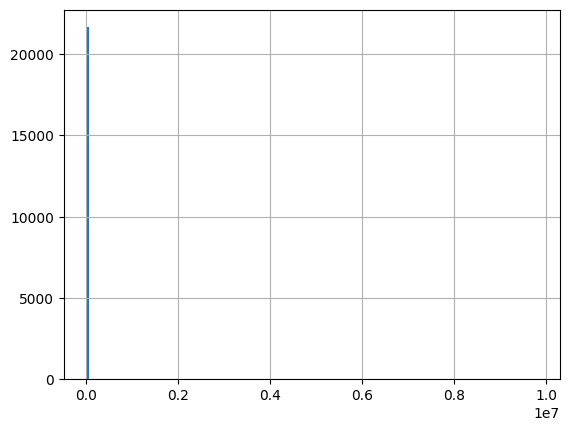

In [56]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
124,19.5,mg/L,NaN,19.5 milligram / liter
125,11.3,mg/L,NaN,11.3 milligram / liter
129,6.7,mg/L,NaN,6.7 milligram / liter
135,28.0,mg/L,NaN,28.0 milligram / liter
...,...,...,...,...
1474780,5.3,mg/L,NaN,5.3 milligram / liter
1474795,16,mg/L,NaN,16.0 milligram / liter
1474863,11,mg/L,NaN,11.0 milligram / liter
1474867,20,mg/L,NaN,20.0 milligram / liter


##### Turbidity (NTU)

-Usable results-
count     93245.000000
mean         16.072727
std         867.733210
min          -0.047700
25%           1.500000
50%           2.400000
75%           4.100000
max      200000.000000
dtype: float64
Unusable results: 1101
Usable results with inferred units: 0
Results outside threshold (0.0 to 5222.471985770489): 155


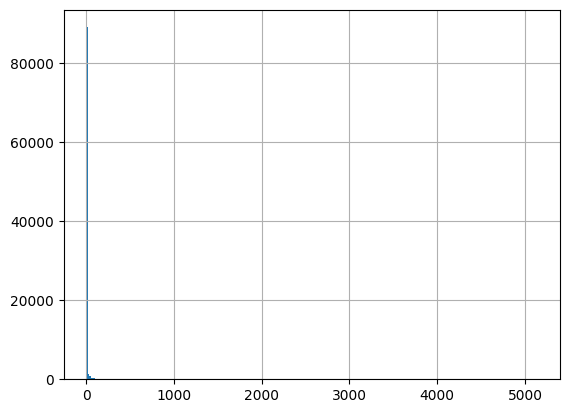

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
25,4.49,NTU,NaN,4.49 Nephelometric_Turbidity_Units
81,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
108,2.9,NTU,NaN,2.9 Nephelometric_Turbidity_Units
147,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
222,4.3,NTU,NaN,4.3 Nephelometric_Turbidity_Units
...,...,...,...,...
1474943,1.5,NTU,NaN,1.5 Nephelometric_Turbidity_Units
1474947,3.7,NTU,NaN,3.7 Nephelometric_Turbidity_Units
1474948,0.8,NTU,NaN,0.8 Nephelometric_Turbidity_Units
1474953,0.8,NTU,NaN,0.8 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
19612,0.050,mg/L,NaN,0.05 milligram / liter
...,...,...,...,...
1474959,0.02,mg/L,NaN,NaN
1474960,0.18,mg/L,NaN,NaN
1474964,0.091,mg/L,NaN,NaN
1474966,0.180,mg/L,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
23731,0.004,mg/L,NaN,NaN
...,...,...,...,...
1474959,0.02,mg/L,NaN,NaN
1474960,0.18,mg/L,NaN,NaN
1474964,0.091,mg/L,NaN,NaN
1474966,0.180,mg/L,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
19612,0.050,mg/L,NaN,0.05 milligram / liter
29925,0.009,mg/L,NaN,0.009 milligram / liter
56000,0.003,mg/L,NaN,0.003 milligram / liter
119455,0.050,mg/L,NaN,0.05 milligram / liter
124393,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1460824,1.0,mg/l as P,NaN,1.0 milligram / liter
1460842,0.93,mg/l as P,NaN,0.93 milligram / liter
1460860,0.58,mg/l as P,NaN,0.58 milligram / liter
1460884,0.48,mg/l as P,NaN,0.48 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
221871,0.13118375,mg/L,NaN,NaN
238638,0.1696225,mg/L,NaN,NaN
239076,0.0835825,mg/L,NaN,NaN
245367,0.16950375,mg/L,NaN,NaN
254999,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1450276,0.058,%,NaN,NaN
1451133,0.041,%,NaN,NaN
1451913,0.078,%,NaN,NaN
1471478,460,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 55593
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988216): 8


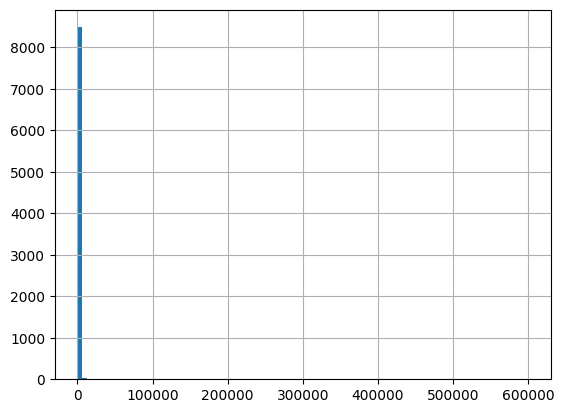

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
13,760,cfu/100mL,NaN,NaN
15,2900,cfu/100mL,NaN,NaN
55,300,#/100mL,NaN,NaN
72,280,#/100mL,NaN,NaN
109,52,cfu/100mL,NaN,NaN
...,...,...,...,...
1474326,50,cfu/100mL,NaN,NaN
1474441,400,MPN/100mL,NaN,NaN
1474510,100,cfu/100mL,NaN,NaN
1474974,860,MPN/100mL,NaN,NaN


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 6413
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


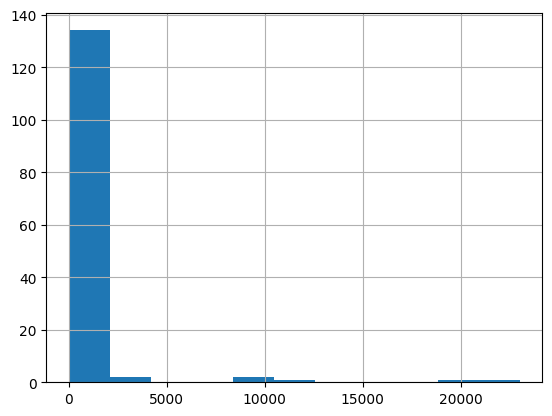

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
275760,210,MPN/100mL,NaN,NaN
277312,4800,MPN/100mL,NaN,NaN
277564,74.5,MPN/100mL,NaN,NaN
277832,553.9,MPN/100mL,NaN,NaN
278394,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1474963,62,MPN/100mL,NaN,NaN
1474967,484,MPN/100mL,NaN,NaN
1474978,116,MPN/100mL,NaN,NaN
1474981,1.0,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 269049 
Mean: 21.708380477587173 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
288102,48930,ppth,NaN,48930.0 Practical_Salinity_Units
389920,76.57,ppth,NaN,76.57 Practical_Salinity_Units
497310,54.8,ppth,NaN,54.8 Practical_Salinity_Units
620734,2976,ppth,NaN,2976.0 Practical_Salinity_Units
645813,68,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25645,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
25646,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46162,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46163,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
373948,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
600312,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
609640,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
695266,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
968090,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
970921,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

481663      626.0 microsiemens / centimeter
486047      688.0 microsiemens / centimeter
503565      606.0 microsiemens / centimeter
504687      606.0 microsiemens / centimeter
507936      633.0 microsiemens / centimeter
520502      775.0 microsiemens / centimeter
523177      776.0 microsiemens / centimeter
524175      776.0 microsiemens / centimeter
526238      776.0 microsiemens / centimeter
531863      775.0 microsiemens / centimeter
878329    20500.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
878329,20500,uS/cm,NaN,NaN,20500.0 microsiemens / centimeter
523177,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
524175,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
526238,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
520502,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
531863,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
486047,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
507936,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
481663,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
503565,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

878329    12.242 dimensionless
523177     0.379 dimensionless
524175     0.379 dimensionless
526238     0.379 dimensionless
520502     0.379 dimensionless
531863     0.379 dimensionless
486047     0.335 dimensionless
507936     0.308 dimensionless
481663     0.304 dimensionless
503565     0.294 dimensionless
504687     0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
878329,2021-09-17,NaN,NaN
523177,2007-08-15,NaN,NaN
524175,2007-08-15,NaN,NaN
526238,2007-08-15,NaN,NaN
520502,2007-08-15,NaN,NaN
...,...,...,...
1478918,1955-04-08,NaN,NaN
1478919,1955-04-08,NaN,NaN
1478920,1957-10-21,14:05:00,EST
1478921,1955-04-08,NaN,NaN


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 100667 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
878329,2021-09-17,NaT
523177,2007-08-15,NaT
524175,2007-08-15,NaT
526238,2007-08-15,NaT
520502,2007-08-15,NaT
...,...,...
1478918,1955-04-08,NaT
1478919,1955-04-08,NaT
1478920,1957-10-21,1957-10-21 19:05:00+00:00
1478921,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

486047     0.95
507936     0.50
481663     0.00
381280     3.00
384199     3.00
           ... 
1471326    0.33
1477066    0.30
1477747    0.33
1478054    0.33
1478063    0.30
Name: ResultDepthHeightMeasure/MeasureValue, Length: 506, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Turbidity,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Chlorophyll,QA_Salinity,QA_Carbon,QA_Temperature,QA_Fecal_Coliform
878329,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,2021-09-17,NaN,NaN,NARS_WQX-NWC_FL-10535,STORET-1040690254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523177,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524175,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526238,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520502,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201115,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478918,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478919,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478920,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,-0500,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478921,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

69079 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_E_coli', 'QA_DO', 'QA_pH',
       'QA_Nitrogen', 'QA_Secchi', 'QA_Turbidity', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Conductivity',
       'QA_Chlorophyll', 'QA_Salinity', 'QA_Carbon', 'QA_Temperature',
       'QA_Fecal_Coliform'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Turbidity,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Chlorophyll,QA_Salinity,QA_Carbon,QA_Temperature,QA_Fecal_Coliform
878329,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,NARS_WQX-NWC_FL-10535,STORET,NaN,NaN,NaN,NaN,12.242 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523177,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524175,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526238,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520502,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_E_coli',
 'QA_DO',
 'QA_pH',
 'QA_Nitrogen',
 'QA_Turbidity',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Conductivity',
 'QA_Salinity',
 'QA_Carbon',
 'QA_Temperature']

<Axes: >

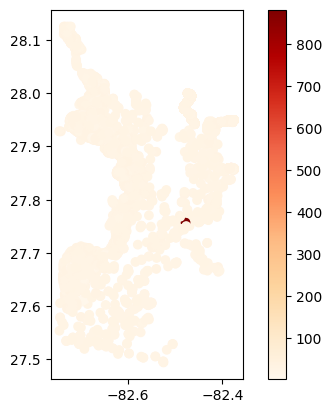

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)